In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern

"""
https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity

1) TPSA(Tot)
2) SAacc
3) H-050
4) MLOGP
5) RDCHI
6) GATS1p
7) nN
8) C-040
9) quantitative response, LC50 [-LOG(mol/L)]

""";

In [2]:
datar = csv.reader(open('qsar_aquatic_toxicity.csv'))
X = []
Y = []
for row in datar:
    row = row[0].split(';')
    x = np.array(row[:-1]).astype(float)
    y = float(row[-1])
    X.append(x)
    Y.append(y)
Y = np.array(Y)
X = np.array(X)
print(X.shape)
scales = []
for ii in range(8):
    scales.append(np.std(X[:,ii]))
scales = np.array(scales)/10.0

(546, 8)


In [3]:
#kernel = RBF(length_scale=scales) + WhiteKernel(noise_level=0.05)
kernel = Matern(length_scale=scales,nu=2.0) + WhiteKernel(noise_level=0.05)


gpr_object = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-10, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=5, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=None)

In [4]:
items = np.arange(0,546)
#np.random.shuffle(items)
X_work = X[ items[:-110] ]
Y_work = Y[ items[:-110] ]
X_test = X[ items[-110:] ]
Y_test = Y[ items[-110:] ]



In [6]:
gpr = gpr_object.fit(X_test, Y_test)

In [99]:
def plot_lml(gp, x_index, y_index):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    import numpy as np
    x = np.logspace(gp.kernel_.bounds[x_index,0],gp.kernel_.bounds[x_index,1], 49)
    y = np.logspace(gp.kernel_.bounds[y_index,0],gp.kernel_.bounds[y_index,1], 50)
    X, Y = np.meshgrid(x,y)

    pt = gp.kernel_.theta
    LML = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pt[x_index] = X[i,j]
            pt[y_index] = Y[i,j]
            LML[i,j] = gp.log_marginal_likelihood(pt)

    LML = -LML

    #LML = LML.T
    vmin, vmax = LML.min(), LML.max()
    level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)

    plt.figure()
    plt.contour(X, Y, LML, levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
                #levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
                #levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.colorbar()
    plt.show()

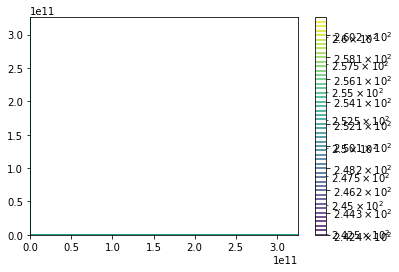

In [101]:
plot_lml(gpr, 4, 5)

In [49]:
vmin, vmax

(242.64110410876572, 50)

In [43]:
np.isnan(LML).any()

False

In [44]:
np.isinf(LML).any()

False

In [6]:
params = []
scores = []

for ii in range(10):
    gpr_object.fit(X_work,Y_work)
    k1 = gpr_object.kernel_.get_params()['k1__length_scale']
    params.append( k1 )
    lml = gpr_object.log_marginal_likelihood_value_
    scores.append(lml)
    ycalc, sigma = gpr_object.predict(X_test, return_std=True)
    #plt.errorbar( Y_test, ycalc, sigma);plt.show()
    R2test = np.corrcoef(Y_test, ycalc)

    ycalc, sigma = gpr_object.predict(X_work, return_std=True)
    #plt.errorbar( Y_work, ycalc, sigma);plt.show()
    R2work = np.corrcoef(Y_work, ycalc)
    print("Trial: %4i   Test R2: %4.3f  --  Work R2:  %4.3f;  Log Marg: Lik. : %4.3e"%(
        ii+1, R2test[0,1], R2work[0,1], lml ))

params=np.array(params)
scores=np.array(scores)

KeyboardInterrupt: 

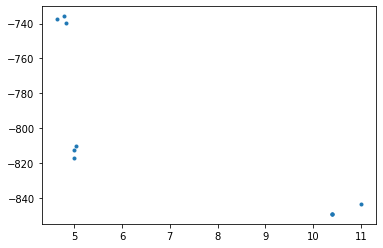

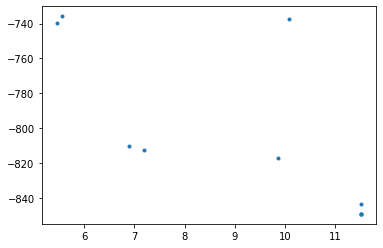

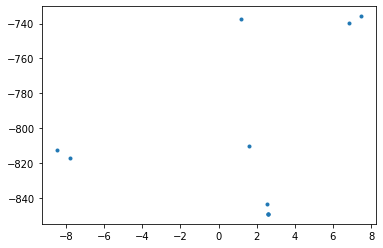

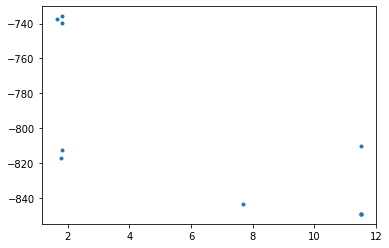

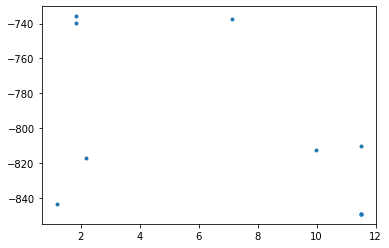

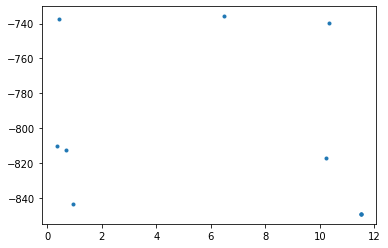

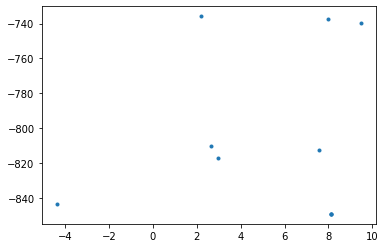

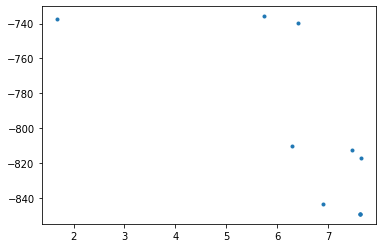

In [6]:
for ii in range(8):
    plt.plot(np.log(params[:,ii]), scores,'.');plt.show()